In [60]:
#导入相应的库
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np  
import itertools
import os

#设置图片的高和宽，一次训练所选取的样本数，迭代次数
im_height = 224
im_width = 224
batch_size = 15
epochs = 2


image_path = "/Users/jiangshihua/Desktop/1/"  # 红细胞数据集路径
train_dir = image_path + "training/training"  #训练集路径
validation_dir = image_path + "validation/validation" #验证集路径

# 定义训练集图像生成器，并进行图像增强
train_image_generator = ImageDataGenerator( rescale=1./255, # 归一化
                                            rotation_range=40, #旋转范围
                                            width_shift_range=0.2, #水平平移范围
                                            height_shift_range=0.2, #垂直平移范围
                                           shear_range=0.2, #剪切变换的程度
                                            zoom_range=0.2, #剪切变换的程度
                                            fill_mode='nearest')
                                            
# 使用图像生成器从文件夹train_dir中读取样本，对标签进行one-hot编码
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir, #从训练集路径读取图片
                                                           batch_size=batch_size, #一次训练所选取的样本数
                                                           shuffle=True, #打乱标签
                                                           target_size=(im_height, im_width), #图片resize到224x224大小
                                                           class_mode='categorical') #one-hot编码
                                                           
# 训练集样本数        
total_train = train_data_gen.n 

# 定义验证集图像生成器，并对图像进行预处理
validation_image_generator = ImageDataGenerator(rescale=1./255) # 归一化

# 使用图像生成器从验证集validation_dir中读取样本
val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir,#从验证集路径读取图片
                                                              batch_size=batch_size, #一次训练所选取的样本数
                                                              shuffle=False,  #不打乱标签
                                                              target_size=(im_height, im_width), #图片resize到224x224大小
                                                              class_mode='categorical') #one-hot编码
                                                              
# 验证集样本数      
total_val = val_data_gen.n


Found 38 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


In [61]:
# from sklearn.model_selection import train_test_split
# from PIL import Image
# import os


# path="/Users/jiangshihua/Desktop/Created Dataset/Level_0/"

# dat= os.listdir(path)

# train, test = train_test_split(dat, test_size = 0.3)

# for file in train:

#     im2 = Image.open("/Users/jiangshihua/Desktop/Created Dataset/Level_0/"+file)
#     im2.save("/Users/jiangshihua/Desktop/Created Dataset/training_0/"+file)

# for file in test:

#     im2 = Image.open("/Users/jiangshihua/Desktop/Created Dataset/Level_0/"+file)
#     im2.save("/Users/jiangshihua/Desktop/Created Dataset/validation_0/"+file)

In [62]:
from keras.callbacks import ReduceLROnPlateau
#from keras.callbacks import EarlyStopping
Reduce=ReduceLROnPlateau(monitor='val_accuracy',
                         factor=0.1,
                         patience=5,
                         verbose=1,
                         mode='auto',
                         epsilon=0.0001,
                         cooldown=0,
                         min_lr=0)

In [9]:
import os
def get_all_file(dir_name):
    fullname_list, filename_list = [], []
    for root, dirs, files in os.walk(dir_name):
        for filename in files:
            # 文件名列表，包含完整路径
            fullname_list.append(os.path.join(root, filename))
            # # 文件名列表，只包含文件名
            filename_list.append(filename)
    return fullname_list, filename_list


In [13]:
load_path = "/Users/jiangshihua/Desktop/facedetector_test/1/training/training/e1/"
save_path = '/Users/jiangshihua/Desktop/facedetector_test/1/training/training/e1_test/'
fullname_list, filename_list = get_all_file(load_path)

In [14]:
#coding=utf-8

import cv2
import dlib

i = 1
cut_coor_min,cut_coor_max = {},{}
#path = "/Users/jiangshihua/Desktop/1/training/training/e0/qingdu (4)1.jpg"
predictor_path = "/Users/jiangshihua/Desktop/shape_predictor_68_face_landmarks.dat"
for path in fullname_list:
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #人脸分类器
    detector = dlib.get_frontal_face_detector()
    # 获取人脸检测器
    predictor = dlib.shape_predictor(
        predictor_path
    )
    
    dets = detector(gray, 1)
    turn = 1
    for face in dets:
        shape = predictor(img, face)  # 寻找人脸的68个标定点
        # 遍历所有点，打印出其坐标，并圈出来
        for pt in shape.parts():
            pt_pos = (pt.x, pt.y)
            cv2.circle(img, pt_pos, 2, (0, 255, 0), 1)
            
            if turn == 1:
                cut_coor_min[i],cut_coor_max[i] = pt_pos,pt_pos
                min_x,max_x,min_y,max_y = pt.x,pt.x,pt.y,pt.y
                turn += 1
            else: 
                if cut_coor_min[i][0] > pt.x and cut_coor_min[i][1] > pt.y:
                    cut_coor_min[i]=(pt.x,pt.y)
                elif cut_coor_min[i][0] > pt.x:
                    cut_coor_min[i]=(pt.x,cut_coor_min[i][1])
                elif cut_coor_min[i][1] > pt.y:
                    cut_coor_min[i]=(cut_coor_min[i][0],pt.y)
                if cut_coor_max[i][0] < pt.x and cut_coor_max[i][1] < pt.y:
                    cut_coor_max[i]=(pt.x,pt.y)  
                elif cut_coor_max[i][0] < pt.x:
                    cut_coor_max[i]=(pt.x,cut_coor_max[i][1])
                elif cut_coor_max[i][1] < pt.y:
                    cut_coor_max[i]=(cut_coor_max[i][0],pt.y) 
                if cut_coor_min[i][0] < 0:
                    cut_coor_min[i] = (0,cut_coor_min[i][1])
                if cut_coor_min[i][1] < 0:
                    cut_coor_min[i] = (cut_coor_min[i][0],0)

            #print(pt_pos)
        #cv2.imshow("image", img)
        #print(shape.parts())
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    #保存图像
    retval = cv2.imwrite(save_path+str(i)+'.jpg', img)
    i+=1
    #print(pt_pos)
    #print(str(i)+":"+str(shape.parts()))

In [15]:
import re
# for path in fullname_list1:
#     img = cv2.imread(path)
# #     print(img.shape)
#     path = "".join(list(filter(str.isdigit, path)))
#     print(path[1:])
#     cropped = img[cut_coor_min[i][1]:cut_coor_max[i][1], 0:512]  # 裁剪坐标为[y0:y1, x0:x1]
# #     cv2.imwrite("./data/cut/cv_cut_thor.jpg", cropped)

# for path in filename_list1:
#     path = "".join(list(filter(str.isdigit, path)))
#     path_int = re.findall("\d+",path)
#     #path = int(float(path))
#     if path_int:
for i in cut_coor_min.keys():
    img = cv2.imread(save_path+str(i)+".jpg")
    #print(img)
#     print(img.shape)
    if cut_coor_min[i][1]-(cut_coor_max[i][1]-cut_coor_min[i][1])*1//4 < 0:
        cropped = img[0:cut_coor_max[i][1], cut_coor_min[i][0]:cut_coor_max[i][0]]  # 裁剪坐标为[y0:y1, x0:x1]
    else:
        cropped = img[cut_coor_min[i][1]-(cut_coor_max[i][1]-cut_coor_min[i][1])*1//4:cut_coor_max[i][1], cut_coor_min[i][0]:cut_coor_max[i][0]]  # 裁剪坐标为[y0:y1, x0:x1]
    cv2.imwrite(save_path+str(i)+'.jpg', cropped)

In [63]:
#使用tf.keras.applications中的InceptionV3网络，并且使用官方的预训练模型
covn_base = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(224,224,3))
covn_base.trainable = True

#冻结前面的层，训练最后20层
for layers in covn_base.layers[:-20]:
    layers.trainable = False
    
#构建模型      
model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling2D()) #加入全局平均池化层
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4,activation='softmax')) #加入输出层(6分类)
model.summary() # 打印每层参数信息   

#编译模型
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), #使用adam优化器，学习率为0.0001
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #交叉熵损失函数
              metrics=["accuracy"]) #评价函数


history = model.fit(x=train_data_gen,   #输入训练集
                    steps_per_epoch=total_train // batch_size, #一个epoch包含的训练步数
                    epochs=epochs, #训练模型迭代次数
                    validation_data=val_data_gen,  #输入验证集
                    validation_steps=total_val // batch_size,
                   callbacks=[Reduce]) #一个epoch包含的训练步数

# 记录训练集和验证集的准确率和损失值
history_dict = history.history
train_loss = history_dict["loss"] #训练集损失值
train_accuracy = history_dict["accuracy"] #训练集准确率
val_loss = history_dict["val_loss"] #验证集损失值
val_accuracy = history_dict["val_accuracy"] #验证集准确率

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 1,943,556
Non-trainable params: 19,867,424
__________________________________

KeyError: 'val_loss'

In [59]:
# # 各个类别评估（X_test为10000个数据集）
# print("[INFO] evaluating network...")
# predictions = model.predict(train_data_gen, batch_size=32) #显示每一个测试集各个类别的概率，这个值的shape为（10000,10）
# print(predictions)
# print(predictions.shape)

In [81]:
import numpy as np
import cv2
predict_path = "/Users/jiangshihua/Desktop/1/test/"
predict_img = validation_image_generator.flow_from_directory(directory=predict_path,#从验证集路径读取图片
                                                              #batch_size=batch_size, #一次训练所选取的样本数
                                                              #shuffle=False,  #不打乱标签
                                                              target_size=(im_height, im_width)) #图片resize到224x224大小
                                                              #class_mode='categorical') #one-hot编码
predictions = model.predict(predict_img, batch_size=32)
y_test_pred = np.argmax(predictions, axis=1)
 
# 注意：axis值为你要转换的行(axis=1从每一行找出最大数值的下标,
# axis=0从每一列找出最大数值的下标)，而且输出为一维数据，即每个样本对应一个类别值

print(train_data_gen.class_indices)
#print(predict_img.filenames)
#print(predictions)
#print(y_test_pred)
for i in range(len(predict_img.filenames)):
    print(predict_img.filenames[i]+"预测结果为-------->"+str(y_test_pred[i]))

Found 3 images belonging to 1 classes.
{'e0': 0, 'e1': 1, 'e2': 2, 'e3': 3}
e0/1.jpeg预测结果为-------->2
e0/2.jpeg预测结果为-------->2
e0/3.jpeg预测结果为-------->1


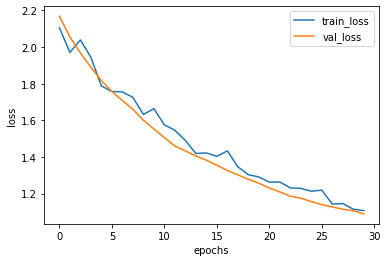

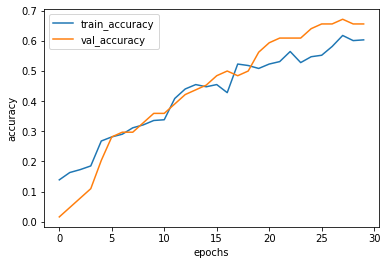

In [78]:
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [5]:
#使用tf.keras.applications中的Xception网络，并且使用官方的预训练模型
covn_base = tf.keras.applications.Xception(weights='imagenet',include_top=False,input_shape=(224,224,3))
covn_base.trainable = True

#冻结前面的层，训练最后20层
for layers in covn_base.layers[:-20]:
    layers.trainable = False
    
#构建模型      
model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling2D()) #加入全局平均池化层
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4,activation='softmax')) #加入输出层(6分类)
model.summary() # 打印每层参数信息   

#编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #使用adam优化器，学习率为0.0001
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #交叉熵损失函数
              metrics=["accuracy"]) #评价函数


history = model.fit(x=train_data_gen,   #输入训练集
                    steps_per_epoch=total_train // batch_size, #一个epoch包含的训练步数
                    epochs=epochs, #训练模型迭代次数
                    validation_data=val_data_gen,  #输入验证集
                    validation_steps=total_val // batch_size,
                   callbacks=[Reduce]) #一个epoch包含的训练步数

# 记录训练集和验证集的准确率和损失值
history_dict = history.history
train_loss = history_dict["loss"] #训练集损失值
train_accuracy = history_dict["accuracy"] #训练集准确率
val_loss = history_dict["val_loss"] #验证集损失值
val_accuracy = history_dict["val_accuracy"] #验证集准确率

2022-08-05 00:50:36.669534: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 7,334,572
Non-trainable params: 13,535,104
____________________________________

KeyError: 'val_loss'

In [ ]:
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
#使用tf.keras.applications中的Xception网络，并且使用官方的预训练模型
covn_base = tf.keras.applications.DenseNet201(weights='imagenet',include_top=False,input_shape=(224,224,3))
covn_base.trainable = True

#冻结前面的层，训练最后20层
for layers in covn_base.layers[:-20]:
    layers.trainable = False
    
#构建模型      
model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling2D()) #加入全局平均池化层
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4,activation='softmax')) #加入输出层(6分类)
model.summary() # 打印每层参数信息   

#编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #使用adam优化器，学习率为0.0001
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #交叉熵损失函数
              metrics=["accuracy"]) #评价函数


history = model.fit(x=train_data_gen,   #输入训练集
                    steps_per_epoch=total_train // batch_size, #一个epoch包含的训练步数
                    epochs=epochs, #训练模型迭代次数
                    validation_data=val_data_gen,  #输入验证集
                    validation_steps=total_val // batch_size,
                   callbacks=[Reduce]) #一个epoch包含的训练步数

# 记录训练集和验证集的准确率和损失值
history_dict = history.history
train_loss = history_dict["loss"] #训练集损失值
train_accuracy = history_dict["accuracy"] #训练集准确率
val_loss = history_dict["val_loss"] #验证集损失值
val_accuracy = history_dict["val_accuracy"] #验证集准确率

In [ ]:
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [81]:
#使用tf.keras.applications中的NASNetLarge网络，并且使用官方的预训练模型
# covn_base = tf.keras.applications.NASNetLarge(weights='imagenet',include_top=False,input_shape=(224,224,3))
# covn_base.trainable = True

#使用tf.keras.applications中的NASNetLarge网络，并且使用官方的预训练模型
covn_base = tf.keras.applications.NASNetLarge(weights='imagenet',include_top=False,input_shape=(331,331,3))
covn_base.trainable = True

#冻结前面的层，训练最后20层
for layers in covn_base.layers[:-20]:
    layers.trainable = False
    
#构建模型      
model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling2D()) #加入全局平均池化层
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(6,activation='softmax')) #加入输出层(6分类)
model.summary() # 打印每层参数信息   

#编译模型
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), #使用adam优化器，学习率为0.0001
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #交叉熵损失函数
              metrics=["accuracy"]) #评价函数


history = model.fit(x=train_data_gen,   #输入训练集
                    steps_per_epoch=total_train // batch_size, #一个epoch包含的训练步数
                    epochs=epochs, #训练模型迭代次数
                    validation_data=val_data_gen,  #输入验证集
                    validation_steps=total_val // batch_size,
                   callbacks=[Reduce]) #一个epoch包含的训练步数

# 记录训练集和验证集的准确率和损失值
history_dict = history.history
train_loss = history_dict["loss"] #训练集损失值
train_accuracy = history_dict["accuracy"] #训练集准确率
val_loss = history_dict["val_loss"] #验证集损失值
val_accuracy = history_dict["val_accuracy"] #验证集准确率

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 dropout_62 (Dropout)        (None, 11, 11, 4032)      0         
                                                                 
 global_average_pooling2d_31  (None, 4032)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_63 (Dropout)        (None, 4032)              0         
                                                                 
 dense_31 (Dense)            (None, 6)                 24198     
                                                                 
Total params: 84,941,016
Trainable params: 2,340,582
Non-trainable params: 82,600,434
_________________________________

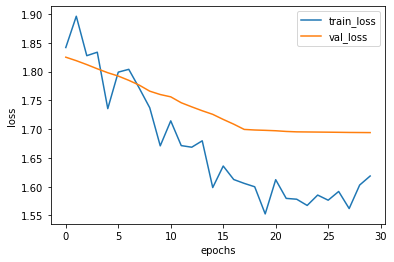

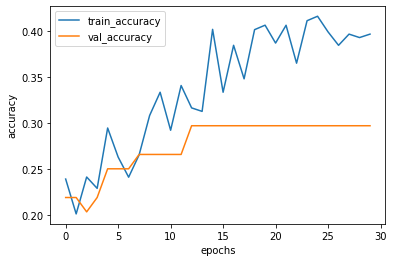

In [82]:
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [4]:
#使用tf.keras.applications中的Xception网络，并且使用官方的预训练模型
covn_base = tf.keras.applications.EfficientNetB7(weights='imagenet',include_top=False,input_shape=(224,224,3))
covn_base.trainable = True

#冻结前面的层，训练最后20层
for layers in covn_base.layers[:-20]:
    layers.trainable = False
    
#构建模型      
model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling2D()) #加入全局平均池化层
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(6,activation='softmax')) #加入输出层(6分类)
model.summary() # 打印每层参数信息   

#编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #使用adam优化器，学习率为0.0001
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #交叉熵损失函数
              metrics=["accuracy"]) #评价函数


history = model.fit(x=train_data_gen,   #输入训练集
                    steps_per_epoch=total_train // batch_size, #一个epoch包含的训练步数
                    epochs=epochs, #训练模型迭代次数
                    validation_data=val_data_gen,  #输入验证集
                    validation_steps=total_val // batch_size,
                   callbacks=[Reduce]) #一个epoch包含的训练步数

# 记录训练集和验证集的准确率和损失值
history_dict = history.history
train_loss = history_dict["loss"] #训练集损失值
train_accuracy = history_dict["accuracy"] #训练集准确率
val_loss = history_dict["val_loss"] #验证集损失值
val_accuracy = history_dict["val_accuracy"] #验证集准确率

258088960/258076736 [==============================] - 21s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 2560)        0         
                                                                 
 global_average_pooling2d_1   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2560)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 15366     
                                                                 
Total params: 64,113,053
Trainable params: 7,858,086

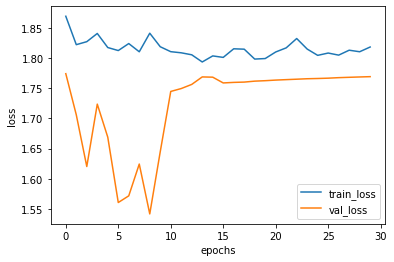

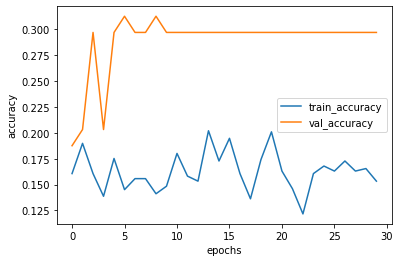

In [68]:
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [69]:
#使用tf.keras.applications中的Xception网络，并且使用官方的预训练模型
covn_base = tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))
covn_base.trainable = True

#冻结前面的层，训练最后20层
for layers in covn_base.layers[:-20]:
    layers.trainable = False
    
#构建模型      
model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling2D()) #加入全局平均池化层
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(6,activation='softmax')) #加入输出层(6分类)
model.summary() # 打印每层参数信息   

#编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #使用adam优化器，学习率为0.0001
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #交叉熵损失函数
              metrics=["accuracy"]) #评价函数


history = model.fit(x=train_data_gen,   #输入训练集
                    steps_per_epoch=total_train // batch_size, #一个epoch包含的训练步数
                    epochs=epochs, #训练模型迭代次数
                    validation_data=val_data_gen,  #输入验证集
                    validation_steps=total_val // batch_size,
                   callbacks=[Reduce]) #一个epoch包含的训练步数

# 记录训练集和验证集的准确率和损失值
history_dict = history.history
train_loss = history_dict["loss"] #训练集损失值
train_accuracy = history_dict["accuracy"] #训练集准确率
val_loss = history_dict["val_loss"] #验证集损失值
val_accuracy = history_dict["val_accuracy"] #验证集准确率

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_50 (Dropout)        (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d_25  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_51 (Dropout)        (None, 1280)              0         
                                                                 
 dense_25 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 1,213,766
N

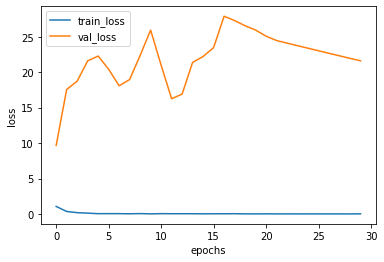

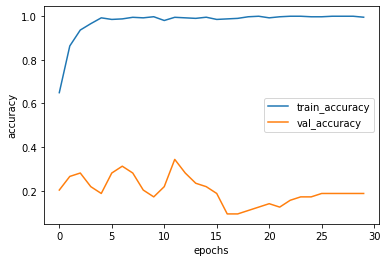

In [70]:
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()